# Logistic Regression and SGD Homework 
***
**Name**: Prathyusha Gayam
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
from numpy import argsort
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [2]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    print("Number of words in vocabulary", len(vocab))

    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
        
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)
    print("Bag of words text model is being used")
    print("Label 1 - Motorcycles\nLabel 0 - automobiles")
    
    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [3]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"

train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

Number of words in vocabulary 5327
Bag of words text model is being used
Label 1 - Motorcycles
Label 0 - automobiles


### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [11]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        self.iteration = []
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 0:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    self.iteration.append(iteration)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                
                iteration += 1
        return self.train_acc, self.iteration, test_acc
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        x = train_example.x
        y = train_example.y
        
        from math import exp
        from numpy import power
        
        sig = self.sigmoid(self.w.dot(x))
        
        self.w = self.w - self.eta*(sig - y)*x
        
        for i in range(1, len(self.w)):
            if i in self.last_update:
                self.last_update[i] += 1
            else:
                self.last_update[i] = 1
        
        for i in range(1, len(self.w)):
            if x[i]!=0:
                self.w[i] = self.w[i] * power((1 - 2*self.eta*self.lam), self.last_update[i])
                
        for i in range(len(x)):
            if x[i]!=0:
                self.last_update[i] = 0

        return self.w
    
    def bike_words(self):
        return argsort(self.w)[-15:]
    def car_words(self):
        return argsort(self.w)[:15]
    def bad_words(self):
        return argsort(abs(self.w[:15]))

In [12]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

Update    -1  TrnNLL  767.504  TstNLL   81.206  TrnA 0.498  TstA 0.534
Update     4  TrnNLL  717.342  TstNLL   82.344  TrnA 0.634  TstA 0.621
Update     9  TrnNLL  884.367  TstNLL   98.658  TrnA 0.533  TstA 0.560
Update    14  TrnNLL  747.770  TstNLL   88.670  TrnA 0.612  TstA 0.655
Update    19  TrnNLL  667.037  TstNLL   80.084  TrnA 0.669  TstA 0.672
Update    24  TrnNLL  517.766  TstNLL   62.968  TrnA 0.778  TstA 0.776
Update    29  TrnNLL  541.486  TstNLL   67.815  TrnA 0.747  TstA 0.767
Update    34  TrnNLL  499.937  TstNLL   62.709  TrnA 0.784  TstA 0.767
Update    39  TrnNLL  474.449  TstNLL   59.565  TrnA 0.801  TstA 0.767
Update    44  TrnNLL  485.238  TstNLL   58.154  TrnA 0.792  TstA 0.767
Update    49  TrnNLL  480.518  TstNLL   57.328  TrnA 0.791  TstA 0.759
Update    54  TrnNLL  447.003  TstNLL   56.664  TrnA 0.817  TstA 0.776
Update    59  TrnNLL  410.538  TstNLL   55.450  TrnA 0.830  TstA 0.776
Update    64  TrnNLL  399.180  TstNLL   53.775  TrnA 0.836  TstA 0.784
Update

Update   584  TrnNLL  145.333  TstNLL   18.712  TrnA 0.952  TstA 0.966
Update   589  TrnNLL  143.343  TstNLL   19.491  TrnA 0.950  TstA 0.940
Update   594  TrnNLL  127.519  TstNLL   16.037  TrnA 0.963  TstA 0.966
Update   599  TrnNLL  132.907  TstNLL   18.711  TrnA 0.961  TstA 0.948
Update   604  TrnNLL  126.386  TstNLL   16.714  TrnA 0.961  TstA 0.957
Update   609  TrnNLL  126.779  TstNLL   17.018  TrnA 0.961  TstA 0.957
Update   614  TrnNLL  127.499  TstNLL   18.042  TrnA 0.962  TstA 0.974
Update   619  TrnNLL  123.300  TstNLL   17.165  TrnA 0.962  TstA 0.974
Update   624  TrnNLL  115.565  TstNLL   14.429  TrnA 0.970  TstA 0.974
Update   629  TrnNLL  115.191  TstNLL   14.430  TrnA 0.969  TstA 0.974
Update   634  TrnNLL  115.049  TstNLL   14.362  TrnA 0.970  TstA 0.974
Update   639  TrnNLL  132.552  TstNLL   19.552  TrnA 0.960  TstA 0.974
Update   644  TrnNLL  122.257  TstNLL   17.099  TrnA 0.963  TstA 0.974
Update   649  TrnNLL  128.934  TstNLL   18.615  TrnA 0.960  TstA 0.966
Update

([0.49814126394052044,
  0.6338289962825279,
  0.5325278810408922,
  0.6115241635687733,
  0.6691449814126395,
  0.7778810408921933,
  0.7472118959107806,
  0.7843866171003717,
  0.8011152416356877,
  0.79182156133829,
  0.7908921933085502,
  0.8169144981412639,
  0.8299256505576208,
  0.8364312267657993,
  0.8364312267657993,
  0.8355018587360595,
  0.8429368029739777,
  0.8596654275092936,
  0.8447955390334573,
  0.8531598513011153,
  0.8717472118959108,
  0.870817843866171,
  0.8736059479553904,
  0.8401486988847584,
  0.8736059479553904,
  0.879182156133829,
  0.8884758364312267,
  0.8884758364312267,
  0.879182156133829,
  0.8782527881040892,
  0.8578066914498141,
  0.8801115241635687,
  0.8912639405204461,
  0.8903345724907064,
  0.8847583643122676,
  0.8968401486988847,
  0.9079925650557621,
  0.9107806691449815,
  0.912639405204461,
  0.9154275092936803,
  0.9117100371747212,
  0.9163568773234201,
  0.9172862453531598,
  0.9182156133828996,
  0.9154275092936803,
  0.91356877323

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [6]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.014s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [7]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

[0.9568965517241379, 0.9568965517241379, 0.9310344827586207, 0.9741379310344828, 0.9224137931034483, 0.9655172413793104, 0.8448275862068966, 0.6982758620689655]


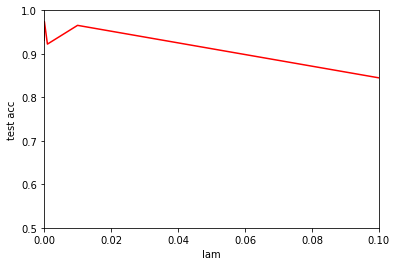

In [15]:
lam = [1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1]
test_acc = []

for each_lam in lam:
    lr = LogReg(train_set, test_set, each_lam, eta=0.1)
    a,b,c = lr.train(isVerbose=False)
    test_acc.append(c)
    
print(test_acc)
plt.xlim(1e-08, 1e-01)
plt.ylim(0.5, 1)
plt.plot(lam, test_acc, c = 'red')
plt.xlabel("lam")
plt.ylabel("test acc")
plt.show()

In [ ]:
The accuarcy is not consistent. Every time I run, i get a different curve. From the chosen lam values, lam = 1e-04 has the highest accuracy on the test set with an accuracy of 97.4%. As the lam values goes high the accuracy on the test set is getting lower maybe beacuse the model is focusing on reducing the weights.

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

Learning rate:  0.1 Iteration: 975 train acc 0.9879182156133829


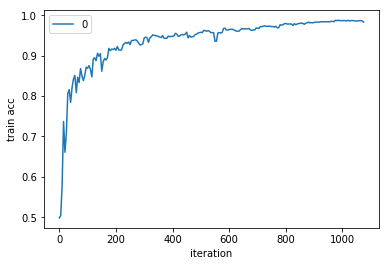

Learning rate:  0.15 Iteration: 1030 train acc 0.9795539033457249


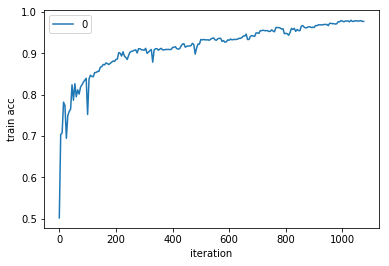

Learning rate:  0.2 Iteration: 990 train acc 0.9758364312267658


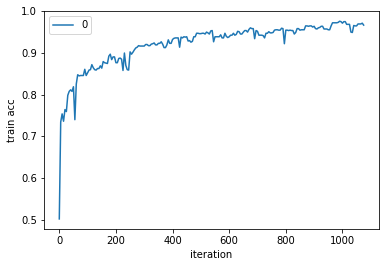

Learning rate:  0.25 Iteration: 1035 train acc 0.9795539033457249


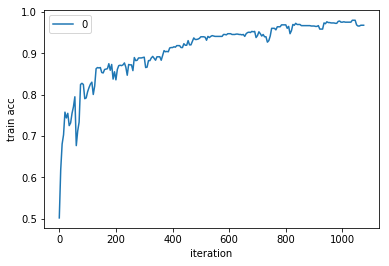

Learning rate:  0.3 Iteration: 1015 train acc 0.9758364312267658


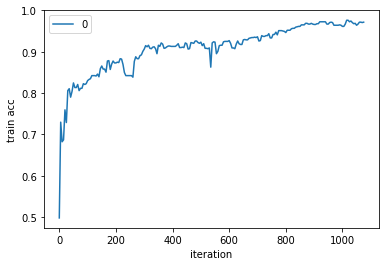

Learning rate:  0.35 Iteration: 1045 train acc 0.9684014869888475


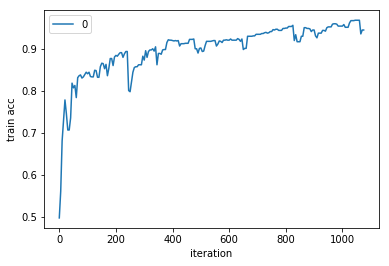

Learning rate:  0.4 Iteration: 1075 train acc 0.9730483271375465


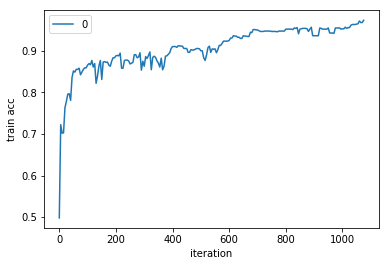

Learning rate:  0.45 Iteration: 1055 train acc 0.9739776951672863


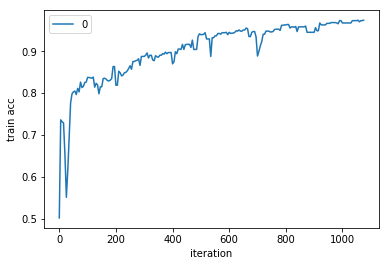

Learning rate:  0.5 Iteration: 1050 train acc 0.9730483271375465


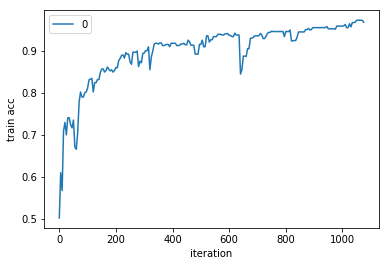

Learning rate:  0.55 Iteration: 865 train acc 0.9684014869888475


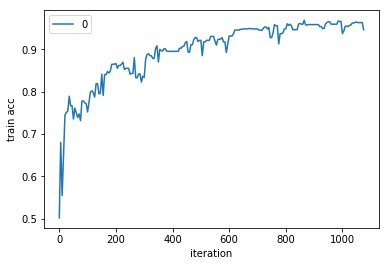

In [26]:
eta = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]

for each_eta in eta:
    lr = LogReg(train_set, test_set, 1e-05, each_eta)
    a, b, c = lr.train(isVerbose=False)
    print("Learning rate: ", each_eta, "Iteration:", b[a.index(max(a))], "train acc", max(a))
    plt.plot(b, a, label = "%d" % each_eta)
    plt.xlabel("iteration")
    plt.ylabel("train acc")
    plt.legend()
    plt.show()

In [ ]:
With increase in learning rate, training accuracy is going down. I observed that learning rate = 0.1 has the highest accuracy of 98.7% on the training set. As learning rate increases the model is taking more number of iterations to converge. So, the speed of convergence is low with increase in learning rate. With the above plots I see that at learning rate. = 0.4 the speed of convergence is low as it took 1075 iterations to converge. At learning rate = 0.55, the training data converged in 865 iterations wih less accuracy.  

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

I got them mathematically, by sorting the weight vector in the ascending order and picking the first and last 15 words. The best predictors for the mototrcycle class (Label 1) are the ones with the highest weight values. The lowest ones are the good predictors for automobile class(label 0) 

In [25]:
def results(lr):
    print("Best predictors for motorcycle class (Label 1)")
    bike = lr.bike_words()
    print([vocab[i] for i in bike])
    
    print("\nBest predictors for automobile class (Label 0)")
    car = lr.car_words()
    print([vocab[i] for i in car])
    
    print("\nWorst predictors for class")
    bad = lr.bad_words()
    print([vocab[i] for i in bad])

results(lr)

Best predictors for motorcycle class (Label 1)
['vt', 'cds', 'stroke', 'sun', 'intake', 'piece', 'pressure', 'list', 'ride', 'cable', 'bikes', 'riding', 'exhaust', 'dod', 'bike']

Best predictors for automobile class (Label 0)
['requests', 'send', 'cars', 'car', 'grand', 'request', 'toyota', 'oil', 'keys', 'concepts', 'spring', 'pocket', 'truck', 'regal', 'thing']

Worst predictors for class
['like', 'distribution', 'much', 'know', 'good', 'think', 'BIAS_CONSTANT', 'new', 'get', 'one', 'time', 'ca', 'car', 'dod', 'bike']


**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

The worst predictors for class are the ones with almost zero weight value, i.e, the words with highest frequency. I took the absolute value of weights and sorted the weight vector and took the first 15 words as the worst predictors for class